# Solution: Problem 2 (magnetars and stellar collapse)

## First, we install packages that we will need. Skip this step if packages are already installed.

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install astropy
!{sys.executable} -m pip install pycbc

## Import necessary packages

In [1]:
from astropy.cosmology import Planck15
from astropy import constants
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pycbc.psd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from tqdm import tqdm

## First, we will do the calculation for stellar collapse models

In [2]:
def Rstar_z(z):
    """
    The star formation rate as a function of redshift.
    Normalized to the merger rate from GWTC-2
    https://arxiv.org/abs/2010.14533
    """
    
    a, b, zm = 2.8, 2.46, 1.72
    nu = 0.146 * u.M_sun / u.yr / u.Mpc ** 3
    numerator = nu * a * np.exp(b * (z - zm))
    denominator = a - b + b * np.exp(a * (z - zm))
    return numerator / denominator

In [3]:
def dEdf_stellar_core_collapse_freq_dependence(freq, a, b, xi):
    """
    Function to calculate dE/df for stellar core collapse.
    """
    freq_dependent_part =  (1 + freq / a) ** 6 * np.exp(- 2*freq/b)
    return freq_dependent_part

def omega_GW_stellar_core_collapse(f_arr, dEdf_function,
                               extra_args=dict()):
    """
    Function to calculate omega_gw given the the dEdf
    distribution. Also takes extra_args that go into the 
    the distribution for chirp mass.
    """
    
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor_numerator = 8 * np.pi * constants.G * freq * extra_args["xi"]
        prefactor_denominator = 3 * Planck15.H0 ** 3 * constants.c ** 2
        integrand = Rstar_z(z) / (1 + z) * Planck15.inv_efunc(z) * dEdf_function(freq * (1 + z), **extra_args) 
        result[index] = prefactor_numerator / prefactor_denominator * np.sum(integrand) * delta_z
    return result


## Calculate omega_gw and compare with the PSD scaled with the constants. Compare with Fig 1 https://arxiv.org/pdf/1701.02638.pdf

598it [00:01, 428.99it/s]
598it [00:01, 441.96it/s]
598it [00:01, 464.37it/s]
598it [00:01, 463.49it/s]


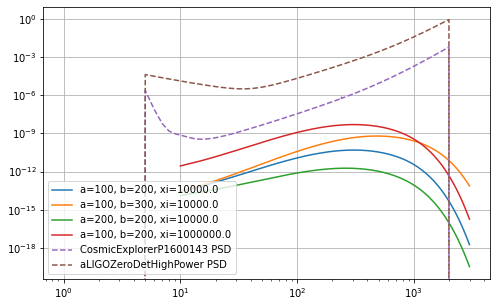

In [4]:
plt.figure(figsize=(8,5))

f_arr = np.arange(10, 3000, 5)
for params in [[100, 200, 1e4], [100, 300, 1e4], [200, 200, 1e4], [100, 200, 1e6]]:
    a, b, xi = params
    omega = omega_GW_stellar_core_collapse(f_arr, dEdf_stellar_core_collapse_freq_dependence,
                            dict(a=a * u.Hz, b=b *u.Hz, xi=xi * u.m**2/u.s))
    plt.loglog(f_arr, omega, label=f"a={a}, b={b}, xi={xi}")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck15.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")

plt.legend()
plt.grid()

## Next, we attack magnetars

In [5]:
def dEdf_magnetars(freq, I, R, B, eps):
    """
    Function to calculate dE/df for stellar core collapse.
    """
    term_1 = I * np.pi ** 2 * freq ** 3
    term_2 = 5 * constants.c ** 2 * R ** 6 * B ** 2 * 4 * np.pi
    term_3 = 192 * np.pi ** 2 * constants.G * I **2 * eps ** 2 * constants.mu0
    
    return term_1 / (term_2 / term_3 + freq ** 2) 

def omega_GW_magnetars(f_arr, lambda_frac, dEdf_function, extra_args=dict()):
    """
    Function to calculate omega_gw given the the dEdf
    distribution. Also takes extra_args that go into the 
    the dEdf function.
    """
    
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck15.critical_density0 * Planck15.H0 * constants.c**2) 
        integrand = lambda_frac* Rstar_z(z) / (1 + z) * Planck15.inv_efunc(z) * dEdf_function(freq * (1 + z), **extra_args) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result


598it [00:01, 359.65it/s]
598it [00:01, 365.42it/s]
598it [00:01, 359.71it/s]
598it [00:01, 362.45it/s]


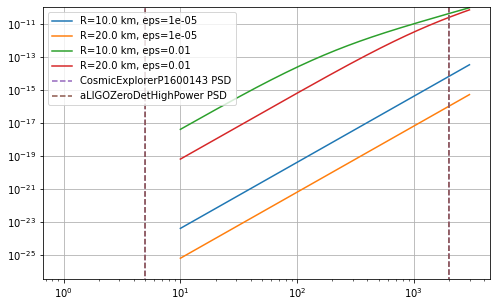

In [6]:
plt.figure(figsize=(8,5))

f_arr = np.arange(10, 3000, 5)
for params in [[1e45, 10, 1e15, 1e-5],
               [1e45, 20, 1e15, 1e-5], 
               [1e45, 10, 1e15, 1e-2],
               [1e45, 20, 1e15, 1e-2]]:
    I, R, B, eps = params
    I = I *u.g * u.cm ** 2
    R = R * u.km
    B = B * u.gauss

    omega = omega_GW_magnetars(f_arr, 1e-7 / u.M_sun, dEdf_magnetars,
                            dict(I=I, R=R, B=B, eps=eps))
    plt.loglog(f_arr, omega, label=f"R={R}, eps={eps}")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck15.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")

plt.legend(loc="best")
plt.ylim(ymax=1e-10)
plt.grid()